In [0]:
import csv
import torch
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def read_csv(filename):
    phrase = []
    label = []

    with open(filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            label.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(label, dtype=int)

    return X, Y


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(
    '/content/drive/My Drive/Colab Notebooks/data/glove.6B.50d.txt')

In [0]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    # number of training examples
    m = X.shape[0]

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    # loop over training examples
    for i in range(m):

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1

    return X_indices

In [6]:
X1 = np.array(["funny love", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny love' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 226278.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a PyTorch Embedding layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer instance
    """

    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1

    # define dimensionality of your GloVe word vectors (= 50)
    emb_dim = word_to_vec_map["cucumber"].shape[0]

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer = nn.Embedding(
        vocab_len, emb_dim, _weight=torch.tensor(emb_matrix))

    return embedding_layer

In [8]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print(embedding_layer.weight.shape)
print(embedding_layer.weight)

torch.Size([400001, 50])
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5840,  0.3903,  0.6528,  ..., -1.2338,  0.4672,  0.7886],
        [-1.0588,  0.2695,  0.9463,  ...,  0.3114,  0.7984,  0.2039],
        ...,
        [ 0.3230,  0.3231, -0.3136,  ...,  1.8267, -0.4305, -1.1958],
        [ 0.3871,  0.0984, -0.7386,  ...,  1.0611, -0.2125, -0.6551],
        [-0.0198, -0.0401,  0.8689,  ...,  0.2371, -0.1819,  0.2477]],
       dtype=torch.float64, requires_grad=True)


In [0]:
X_train, Y_train = read_csv(
    '/content/drive/My Drive/Colab Notebooks/data/train_emoji.csv')
X_test, Y_test = read_csv(
    '/content/drive/My Drive/Colab Notebooks/data/test_emoji.csv')

In [0]:
X_train_indices = sentences_to_indices(X_train, word_to_index, 10)
# Y_train_oh = convert_to_one_hot(Y_train, C=5)

X_test_indices = sentences_to_indices(X_test, word_to_index, 10)
# Y_test_oh = convert_to_one_hot(Y_test, C=5)

In [0]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_indices),
    torch.tensor(Y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test_indices),
    torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

#         self.embedding = nn.Embedding(400001, 50)
        self.embedding = pretrained_embedding_layer(word_to_vec_map,
                                                    word_to_index)
        self.lstm = nn.LSTM(50, 256, 2, dropout=0.5, batch_first=True)

        # linear and sigmoid layers
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 5)
        self.act = nn.Softmax(dim=1)
#         self.act = nn.LogSoftmax(dim=1)

    def forward(self, x):
        #x = x.type(torch.LongTensor)
        x = x.type(torch.cuda.LongTensor)
        x = self.embedding(x)
        #x = x.type(torch.FloatTensor)
        x = x.type(torch.cuda.FloatTensor)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        x = self.act(x)
        return x

Epoch:   0/049 Training loss: 1.60750148 Testing loss: 1.59998757 Test accuracy: 29.688
Epoch:   1/049 Training loss: 1.59290931 Testing loss: 1.56922442 Test accuracy: 26.042
Epoch:   2/049 Training loss: 1.56900544 Testing loss: 1.55112851 Test accuracy: 26.042
Epoch:   3/049 Training loss: 1.57372983 Testing loss: 1.53617483 Test accuracy: 35.417
Epoch:   4/049 Training loss: 1.54914029 Testing loss: 1.52974814 Test accuracy: 35.938
Epoch:   5/049 Training loss: 1.52451634 Testing loss: 1.52666277 Test accuracy: 35.938
Epoch:   6/049 Training loss: 1.48056242 Testing loss: 1.53889740 Test accuracy: 32.812
Epoch:   7/049 Training loss: 1.46266229 Testing loss: 1.53738922 Test accuracy: 35.417
Epoch:   8/049 Training loss: 1.44245982 Testing loss: 1.53422099 Test accuracy: 36.458
Epoch:   9/049 Training loss: 1.45087709 Testing loss: 1.53513992 Test accuracy: 35.417
Epoch:  10/049 Training loss: 1.40904922 Testing loss: 1.50260091 Test accuracy: 34.896
Epoch:  11/049 Training loss: 1.

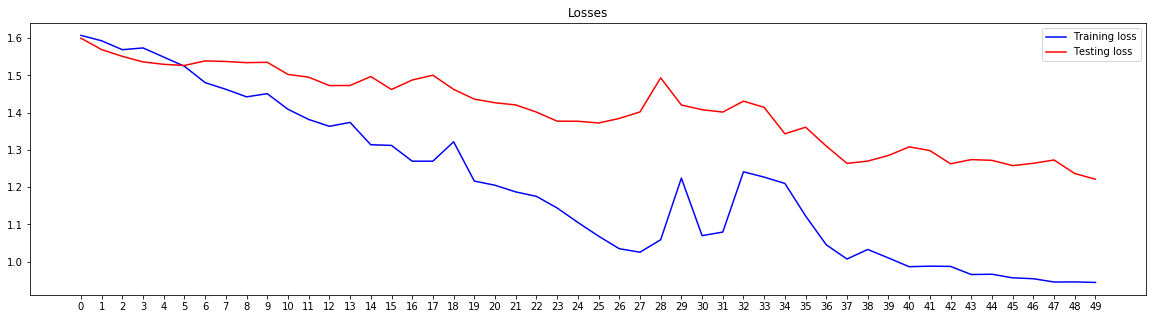

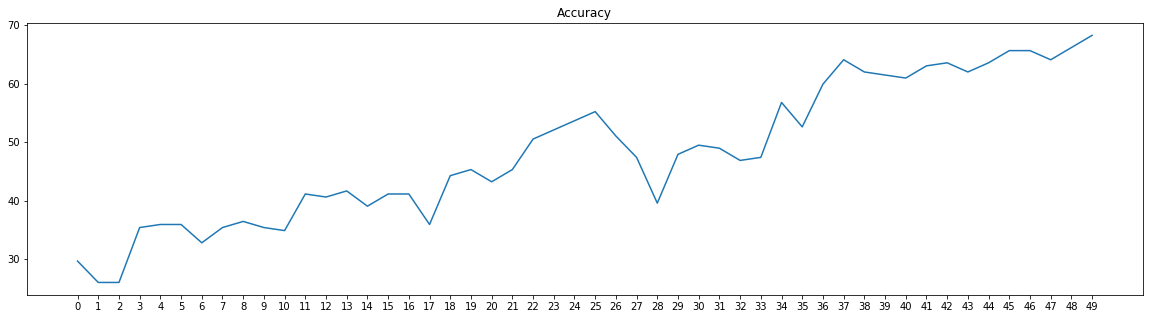

In [15]:
model = Model()
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

epochs = 50
trl, tsl, ac = [], [], []
for epoch in range(epochs):
    model.train()
    train_losses, test_losses = 0, 0
    for sentences, labels in train_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model.forward(sentences)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()
    else:
        model.eval()
        accuracy = 0
        with torch.no_grad():
            for sentences, labels in test_loader:
                sentences, labels = sentences.to(device), labels.to(device)
                pred = model.forward(sentences)
                loss = criterion(pred, labels)
                test_losses += loss.item()

                ps = torch.exp(pred)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        print(
            "Epoch: {:3d}/{:03d} Training loss: {:.8f} Testing loss: {:.8f} Test accuracy: {:0.3f}"
            .format(epoch, epochs-1, (train_losses / len(train_loader)),
                    (test_losses / len(test_loader)),
                    (accuracy / len(test_loader) * 100)))
        trl.append(train_losses / len(train_loader))
        tsl.append(test_losses / len(test_loader))
        ac.append(accuracy / len(test_loader) * 100)

plt.figure(figsize=(20, 5))
plt.plot(trl, c='b', label='Training loss')
plt.plot(tsl, c='r', label='Testing loss')
plt.xticks(np.arange(0, epochs))
plt.title('Losses')
plt.legend(loc='upper right')
plt.show()
plt.figure(figsize=(20, 5))
plt.plot(ac)
plt.xticks(np.arange(0, epochs))
plt.title('Accuracy')
plt.show()